# ERA5 processing

This notebook demonstrates how data processing with the ERA5 products has been carried out for the study.

We start with importing the required modules

In [35]:
import os
import configparser
import warnings
from math import ceil
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.patches import Circle
from tqdm import tqdm 
import datetime
import seaborn as sb
import scipy as sp
from skimage.measure import label, regionprops, regionprops_table
from pylab import size
import math

from metpy import calc as mpcalc
from metpy.calc import wind_direction
from metpy.units import units

from scipy.stats import gaussian_kde
from numpy import linspace


from src import analysis as ay
from src import plotting_functions as pf

import eurec4a

## Reading and preparing dataset for analysis

A config file (`CONFIG.ini`) provides the paths to where the ERA5 dataset has been stored in netcdf format.

In [36]:
config = configparser.ConfigParser()
config.read('CONFIG.ini')
data_directory = config['ERA5']['data_directory']

Reading ERA5 data for the EUREC4A and the CGILS domain

In [3]:
# EUREC4A Domain
era5 = xr.open_dataset(os.path.join(data_directory,config['ERA5']['eurec4a'])).sortby('latitude').sel(time=slice('2020-01-20','2020-02-20')) 

# CGILS Domain
era5_cgils = xr.open_dataset(os.path.join(data_directory,config['ERA5']['cgils'])).sortby('latitude').sel(time=slice('2020-01-20','2020-02-20'))

### Pressure to altitude levels 

To keep the definitions of sub-cloud and cloud layers consistent between the JOANNE and ERA5 processing, we change the vertical coordinates of ERA5 from its native pressure levels (hPa) to altitude (m). The function called here defines how this is done. For getting the altitude-pressure profiles, we resort to JOANNE's mean pressure profile. Reading JOANNE data is the same as that explained in the JOANNE processing notebook.

In [4]:
cat = eurec4a.get_intake_catalog(use_ipfs="QmahMN2wgPauHYkkiTGoG2TpPBmj3p5FoYJAq9uE9iXT9N")
jo_l4 = cat.dropsondes.JOANNE.level4.to_dask()
eurec4a_circles = jo_l4.where(
    jo_l4.platform_id =='HALO',drop=True).swap_dims({'circle':'circle_time'}).sel(circle_time=slice('2020-01-20','2020-02-14'))

In [5]:
era5_cgils = ay.fit_pressure_to_altitude(eurec4a_circles,era5_cgils)
era5 = ay.fit_pressure_to_altitude(eurec4a_circles,era5)

In [6]:
layers = {'sc':{'base':0,'top':600},
          'c':{'base':900,'top':1500},
          'cb':{'base':600,'top':900}}

variable = 'd' # divergence
for dataset in [era5,era5_cgils]:
    for layer in ['sc','c']:
        # Computing mean divergence over sub-cloud and cloud layers
        dataset[f'{layer}_{variable}'] = ay.compute_over_layer(dataset,variable,layers[layer]['base'],layers[layer]['top'])
        # Getting their anomalies from mean
        dataset[f'{layer}_{variable}_ano'] = dataset[f'{layer}_{variable}'] - dataset[f'{layer}_{variable}'].mean()

We already have enough now to plot Extended Data Figs. 1 & 2

### Extended Data - Figure 1

In [7]:
# Co-locating ERA5 & JOANNE in space and time

# Horizontal space
circle_lat_low = 12.2
circle_lat_high = 14.3

circle_lon_low = -58.7
circle_lon_high = -56.8

era5_cir = era5.sel(latitude=slice(circle_lat_low,
                                   circle_lat_high)).sel(longitude=slice(circle_lon_low,
                                                                        circle_lon_high))

# Time
era5_for_l4 = era5_cir.sel(time=eurec4a_circles.circle_time.values,method='nearest')

# Vertical space
l4_for_era5 = eurec4a_circles.sel(alt=era5_cir.alt.values,method='nearest')
l4_for_era5['alt'] = l4_for_era5.alt.astype('float')
l4_for_era5['time'] = (['circle_time'],era5_for_l4.time.values)
l4_for_era5 = l4_for_era5.swap_dims({'circle_time':'time'})

l4_for_era5_daily = l4_for_era5.groupby('time.dayofyear').mean()

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", message="Degrees of freedom <= 0 for slice.")

    l4_for_era5_daily_std = l4_for_era5.groupby('time.dayofyear').std()
    
era5_for_l4_daily = era5_for_l4.groupby('time.dayofyear').mean()
era5_for_l4_daily_std = era5_for_l4.groupby('time.dayofyear').std()

100%|██████████| 11/11 [00:02<00:00,  3.92it/s]


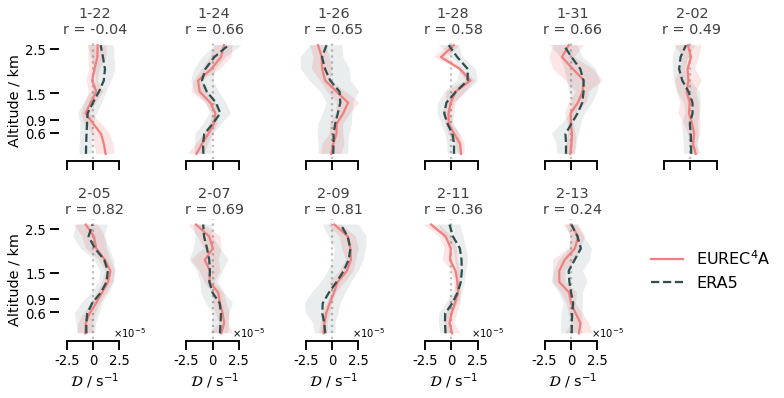

In [9]:
days = l4_for_era5_daily.dayofyear.values
rows = 2
cols = ceil(len(days) / rows)

sb.set_palette(['lightcoral','darkslategrey'])#,n_colors=2)
sb.set_context('talk',font_scale=0.8)
f,ax = plt.subplots(rows,cols,figsize=(12,5.5),sharex=True)#,sharey=True)
plt.subplots_adjust(hspace=0.5,wspace=0.65)

low_alt = 0; high_alt = 2600
row = 0; col =0

exp_coeff = 1

for id_,i in enumerate(tqdm(days)) :
    
    ax[row,col].axvline(0,c='k',linestyle=':',alpha=0.25)
    
    ax[row,col].plot(l4_for_era5_daily.sel(dayofyear=i).D.sel(alt=slice(low_alt,high_alt))*exp_coeff,
                     l4_for_era5_daily.alt.sel(alt=slice(low_alt,high_alt)),
                     label='EUREC$^4$A')
    ax[row,col].plot(era5_for_l4_daily.sel(dayofyear=i).d.mean(
        dim=['latitude','longitude']).sel(alt=slice(low_alt,high_alt))*exp_coeff,
                     era5_for_l4_daily.alt.sel(alt=slice(low_alt,high_alt)),
                     label='ERA5',linestyle='--',)#marker='o',markersize=2)
    
    std_low_l4 = l4_for_era5_daily.sel(dayofyear=i).D.sel(
        alt=slice(low_alt,high_alt)) - l4_for_era5_daily_std.sel(dayofyear=i).D.sel(alt=slice(low_alt,high_alt))
    std_high_l4 = l4_for_era5_daily.sel(dayofyear=i).D.sel(
        alt=slice(low_alt,high_alt)) + l4_for_era5_daily_std.sel(dayofyear=i).D.sel(alt=slice(low_alt,high_alt))
    
    std_low_era5 = era5_for_l4_daily.sel(dayofyear=i).d.mean(
        dim=['latitude','longitude']).sel(alt=slice(low_alt,high_alt)) - era5_for_l4_daily_std.sel(dayofyear=i).d.mean(
        dim=['latitude','longitude']).sel(alt=slice(low_alt,high_alt))
    
    std_high_era5 = era5_for_l4_daily.sel(dayofyear=i).d.mean(
        dim=['latitude','longitude']).sel(alt=slice(low_alt,high_alt)) + era5_for_l4_daily_std.sel(dayofyear=i).d.mean(
        dim=['latitude','longitude']).sel(alt=slice(low_alt,high_alt))
    
    ax[row,col].fill_betweenx(l4_for_era5_daily_std.alt.sel(alt=slice(low_alt,high_alt)),
                              std_low_l4*exp_coeff,std_high_l4*exp_coeff,alpha=0.2)
    ax[row,col].fill_betweenx(era5_for_l4_daily_std.alt.sel(alt=slice(low_alt,high_alt)),
                              std_low_era5*exp_coeff,std_high_era5*exp_coeff,alpha=0.1)
    
    date = datetime.datetime.strptime(f'2020 {i}', '%Y %j').strftime('%Y-%m-%d')
    
    x = l4_for_era5.sel(time=date).D.sel(alt=slice(low_alt,high_alt)).values.flatten()
    y = era5_for_l4.sel(time=date).d.mean(dim=['latitude','longitude']).sel(alt=slice(low_alt,high_alt)).values.flatten()
    
    nas = np.logical_or(np.isnan(x), np.isnan(y))
    
    r, _ = sp.stats.pearsonr(x[~nas],y[~nas])
    ax[row,col].set_title(datetime.datetime.strptime(f'2020 {i}', '%Y %j').strftime('%-m-%d') + '\nr = {:.2f}'.format(r),
                          color='k',alpha=0.75)
    
    ax[1,col].set_xlabel('')
    ax[1,col].set_xlabel('$\mathcal{D}$ / s$^{-1}$')
    
    if len(days) % 2 != 0:
        ax[-1,-1].axis('off')
        if i == days[-1] :
            ax[row,col].legend(loc=(1.5,0.35),frameon=False,fontsize=16)
        if col != cols-1 and row != rows-1:
            pf.sci_exp_axis(ax[1,col])
    else:
        ax[row,col].set_ylim(low_alt,high_alt)        
        if i == days[-1] :
            ax[row,col].legend(loc=(-5.5,-0.75),ncol=2,frameon=False,fontsize=16)
    
    ax[row,col].set_ylabel('')
    ax[row,col].spines['left'].set_visible(False)
    ax[row,col].set_yticks([])

    ax[row,0].set_ylabel('Altitude / km')
    yticks = [600,900,1500,2500]
    ax[row,0].set_yticks(yticks)
    ax[row,0].set_yticklabels(np.array(yticks)/1000)
    
    if col == cols - 1 :
        row += 1
        col = 0
    else :
        col += 1
        
ax[1,col].set_xticks([-2.5e-5,0,2.5e-5])
ax[1,col].set_xticklabels(['-2.5','0','2.5'])        
            
sb.despine(offset=2,left=True,trim=True)

# plt.savefig(f'sandbox/JO_ERA5_profile_comparison_mean_and_std_from_{low_alt}_to_{high_alt}_m_custom_yticks.pdf',
#             bbox_inches='tight')

### Extended Data - Figure 2

100%|██████████| 64/64 [00:40<00:00,  1.59it/s]


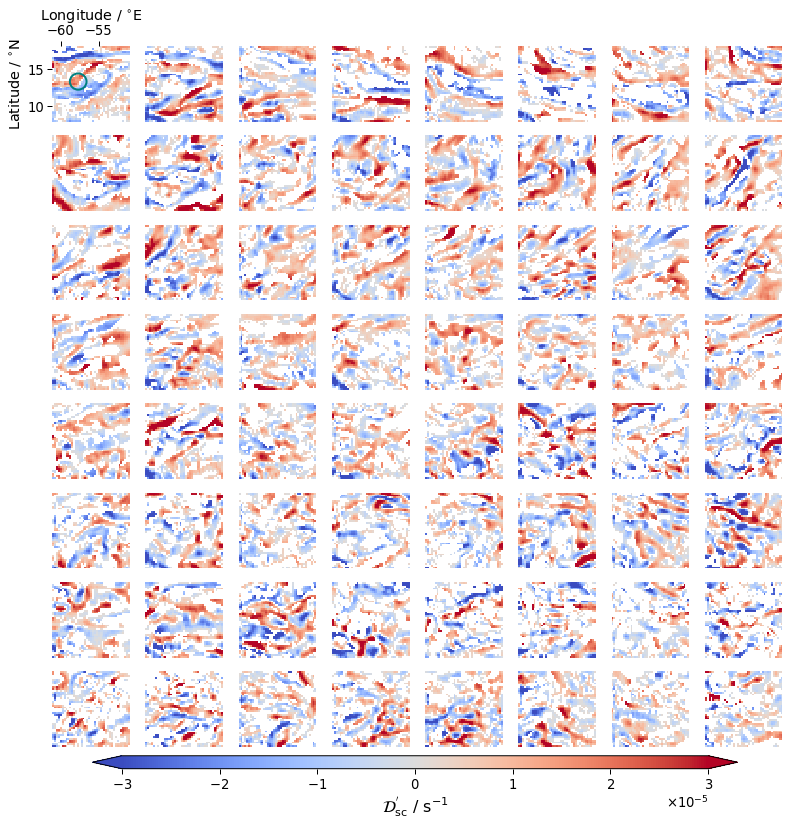

In [17]:
sb.set_context('paper',font_scale=1.5)

lim_no = 12
total_times = ceil(len(era5.time) / lim_no)

cols = 8
rows = ceil(total_times / cols)

row = 0; col = 0
f,ax = plt.subplots(rows,cols,figsize=(cols*1.4,rows*1.5))
plt.subplots_adjust(hspace=0.01,wspace=0.01)

for iterations,time in enumerate(tqdm(era5.time.values[::lim_no])) :
    
    im = era5.where(era5['sc_d_ano'] / era5['c_d_ano'] < 0).sc_d.sel(time=time).plot(ax=ax[row,col],
    cmap='coolwarm',add_colorbar=False,vmin=-3e-5,vmax=3e-5)

    ax[row,col].set_xlabel('')
    ax[row,col].set_ylabel('')
    ax[row,col].set_title('')

    if row == 0 and col == 0:
        ax[row,col].xaxis.tick_top()
        ax[row,col].set_ylabel('Latitude / $^{\circ}$N')
        ax[row,col].set_xlabel('Longitude / $^{\circ}$E')
        ax[row,col].xaxis.set_label_position('top') 
        ax[row,col].set_yticks(np.arange(10,18.1,5))
        ax[row,col].set_xticks(np.arange(-60,-52,5))
        patches = Circle((-57.7,13.3), 1.1, color='teal',fill=False,linestyle='-',linewidth=2)
        ax[row,col].add_patch(patches)
        
    else :
        ax[row,col].set_xticks([])
        ax[row,col].set_yticks([])

    if col < cols - 1 :
        col += 1
    else :
        row += 1
        col = 0 

    if iterations == len(era5.time[::lim_no])-1:
        f.tight_layout()
        
        f.subplots_adjust(bottom=0.125)#, hspace=0.025, wspace=0.025)
        cbar_ax = f.add_axes([0.125, 0.1, 0.8, 1.5e-2])
        fmt = mpl.ticker.ScalarFormatter(useMathText=True)
        cb = f.colorbar(im, cax=cbar_ax,extend='both',
                   orientation='horizontal',format=fmt);
        cb.set_label(label='$\mathcal{D}^{\'}_{\mathrm{sc}}$ / s$^{-1}$',size=16)
        
        last_row = row
        last_col = col
        
        no_rows = np.arange(last_row,rows,1)
        no_cols = np.arange(last_col,cols,1)

        [ax[no_row,col].set_visible(False) for no_row in no_rows for col in range(cols)]
    
    sb.despine(left=True,bottom=True)

# plt.savefig('sandbox/eurec4a_domain_12h_sub_cloud_divergence_anomaly_for_grids_where_cloud_to_sub_cloud_div_ano_ratio_is_negative_cloud_900_to_1500_large_domain.pdf')

In [52]:
dates = np.unique(pd.DatetimeIndex(l4_for_era5.time.values).date)
era5_for_l4 = era5_for_l4.rename_vars({'d':'D'})

# Estimating RMSE

# define data with variable attributes
data_vars = {'empty':(['time','alt'],np.full((len(dates),len(l4_for_era5.alt.values)),np.nan))}

ds_rmse = xr.Dataset(data_vars,
                  coords={'time':dates,'alt':l4_for_era5.alt.values})

for par in tqdm(['u','v','D']) :

    squared_errors = ((l4_for_era5[par] - era5_for_l4[par].mean(dim=['latitude','longitude']))**2)

    rmse = np.full((len(dates),len(squared_errors.alt)),np.nan)

    g = 0
    for i in tqdm(dates,leave=False):
        rmse[g,:] = np.sqrt(squared_errors.sel(time=str(i)).mean(dim='time').values)
        g += 1
        
    ds_rmse[par] = (['time','alt'],rmse)
    
u_sq_err = (l4_for_era5['u'] - era5_for_l4['u'].mean(dim=['latitude','longitude']))**2
v_sq_err = (l4_for_era5['v'] - era5_for_l4['v'].mean(dim=['latitude','longitude']))**2

rmse = np.full((len(dates),len(u_sq_err.alt)),np.nan)
norm_rmse = np.full((len(dates),len(u_sq_err.alt)),np.nan)

g = 0
for i in tqdm(dates,leave=False):
    rmse[g,:] = np.sqrt((u_sq_err.sel(time=str(i)) + v_sq_err.sel(time=str(i))).mean(dim='time').values)
    norm_rmse[g,:] = np.sqrt((u_sq_err.sel(time=str(i)) 
                              + v_sq_err.sel(time=str(i))).mean(dim='time').values) / l4_for_era5.u.sel(time=i.strftime('%Y-%m-%d')).mean(dim='time')
    g += 1
                        
ds_rmse['u_v'] = (['time','alt'],rmse)
ds_rmse['norm_u_v'] = (['time','alt'],norm_rmse)
ds_rmse = ds_rmse.where(ds_rmse.time != datetime.date(2020, 2, 15),drop=True)

100%|██████████| 3/3 [00:00<00:00,  7.61it/s]


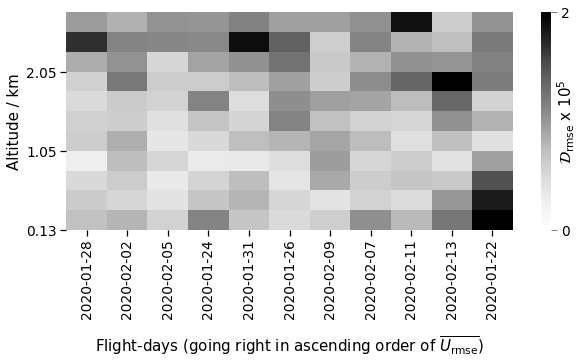

In [57]:
low_alt = 0; high_alt = 2600

sorted_dates = ds_rmse.sortby(ds_rmse.sel(alt=slice(low_alt,high_alt)).u_v.mean(dim='alt')).time

plt.figure(figsize=(10,4))
plt.pcolormesh((ds_rmse.sortby(ds_rmse.sel(alt=slice(low_alt,high_alt)).u_v.mean(dim='alt')).D.sel(alt=slice(low_alt,high_alt)) * 10**5).T,
               cmap='Greys',vmin=0,vmax=2)
cbar = plt.colorbar()
cbar.set_label('$\mathcal{D}_{\mathrm{rmse}}$ x 10$^{5}$',labelpad=-14.5)
plt.xticks(np.arange(0.5,len(sorted_dates.time),1),[i.values for i in sorted_dates],rotation=90);
yticks = np.arange(0,size(ds_rmse.sel(alt=slice(low_alt,high_alt)).alt),4)
plt.yticks(yticks,ds_rmse.sel(alt=slice(low_alt,high_alt)).alt.values[yticks]/1000)
plt.ylabel('Altitude / km')
plt.xlabel('Flight-days (going right in ascending order of $\\overline{U_{\mathrm{rmse}}}$)',labelpad=15)
sb.despine(left=True,bottom=True)

cbar.outline.set_visible(False)
cbar.set_ticks([0,2])
cbar.ax.tick_params(width=.5)
plt.savefig(f'sandbox/daily_Drmse_sorted_by_mean_Urmse_from_{low_alt}_to_{high_alt}_m.pdf',bbox_inches='tight')

## Object segmentation

The details of object segmentation and their connectivity sensitivities are detailed in the manuscript. 

Let's start by reading in the ERA5 data over a larger EUREC4A domain. For the object segmentation, we resort to a different file of the ERA5 dataset with a larger domain. However, it cannot be used for the earlier analysis, as all relevant upper levels are not included. This only occurs because of a local file setting on our side. Readers enthusiastic about reproducing the figures in the manuscript should be able to do so with a single ERA5 data file containing relevant variables for January-February 2020 over 7 to 19 $^{\circ}$ N and -62 to -50 $^{\circ}$ E up to ~4 km altitude.

In [63]:
era5 = xr.open_dataset(os.path.join(data_directory,config['ERA5']['eurec4a_large'])).sortby('latitude').sel(time=slice('2020-01-20','2020-02-20')) 

era5 = ay.fit_pressure_to_altitude(eurec4a_circles,era5)

layers = {'sc':{'base':0,'top':600},
          'c':{'base':900,'top':1500},
          'cb':{'base':600,'top':900}}

variable = 'd' # divergence
for dataset in [era5,era5_cgils]:
    for layer in ['sc','c']:
        # Computing mean divergence over sub-cloud and cloud layers
        dataset[f'{layer}_{variable}'] = ay.compute_over_layer(dataset,variable,layers[layer]['base'],layers[layer]['top'])
        # Getting their anomalies from mean
        dataset[f'{layer}_{variable}_ano'] = dataset[f'{layer}_{variable}'] - dataset[f'{layer}_{variable}'].mean()

We distinguish SMOC grids by checking if a divergence dipole exists in the vertical, i.e. sign of divergence changes between the sub-cloud and cloud layers.

Here, the variable `X` acts as a mask for such grids, defined as following:

    0 : grid doesn't have a dipole
    1 : grid has a dipole with sub-cloud divergence (positive `sc_d`)
    -1 : grid has a dipole with sub-cloud convergence (negative `sc_d`)

The `Y` variable is a copy of the `sc_d` variable with all grids without a dipole showing NaN values. This comes in handy later for plotting.

In [64]:
X = np.full_like(era5['sc_d'],0)

X[np.where((era5['sc_d']/era5['c_d'] < 0) & (era5['sc_d'] < 0))] = -1
X[np.where((era5['sc_d']/era5['c_d'] < 0) & (era5['sc_d'] > 0))] = 1

era5['X'] = (['time','latitude','longitude'],X)

Y = era5['sc_d'].values.copy()
Y[np.where(era5['sc_d']/era5['c_d'] >= 0)] = np.nan

era5['Y'] = (['time','latitude','longitude'],Y)

Now we detect SMOC objects in a sub-cloud divergence (`sc_d`) space with a connectivity of 2. Properties such as `area`, `equivalent_diameter_area`, `axis_major_length`, `axis_minor_length`, `eccentricity`, `orientation` and `centroid` are stored for each object with the same respective variable names.

We introduce a new `xarray.Dataset` called `ds_all` to incorporate both the ERA5 and the object variables into one. This makes life easy later. ;)

In [78]:
df_list = [None] * size(era5.time)

for i_id,i in enumerate(tqdm(era5.time)):

    label_X = label(era5.X.sel(time=i),connectivity=2)

    df = pd.DataFrame(regionprops_table(label_X,era5.sc_d.sel(time=i).values,
                                         properties=('area',
                                                    'equivalent_diameter_area',
                                                    'axis_major_length',
                                                    'axis_minor_length',
                                                    'eccentricity',
                                                    'orientation',
                                                    'centroid',
                                                    )))
    df_list[i_id] = df[df.axis_major_length > 3]

df_all = pd.concat(df_list,keys=range(size(X,0)))

ds = df_all.to_xarray().rename_dims({'level_0':'time','level_1':'objects'}).reset_coords().drop(['level_0','level_1'])
ds_all = xr.merge([era5,ds])


100%|██████████| 768/768 [00:11<00:00, 67.87it/s]


Next, we want to estimate the orientation of the SMOC objects with respect to mean wind. 

In [79]:
ds_all['u_sc'] = ds_all.u.sel(alt=slice(0,610)).mean(dim='alt')
ds_all['v_sc'] = ds_all.v.sel(alt=slice(0,610)).mean(dim='alt')

ds_all['u_cb'] = ds_all.u.sel(alt=slice(600,910)).mean(dim='alt')
ds_all['v_cb'] = ds_all.v.sel(alt=slice(600,910)).mean(dim='alt')

ds_all['wspd'] = np.sqrt(ds_all.u_sc**2 + ds_all.v_sc**2)
ds_all['wspd_cb'] = np.sqrt(ds_all.u_cb**2 + ds_all.v_cb**2)

ds_all['wind_dir'] = (ds_all.u_sc.dims,wind_direction(ds_all.u_sc.values*units('m/s'),ds_all.v_sc.values*units('m/s')).magnitude)
ds_all['wind_dir_cb'] = (ds_all.u_cb.dims,wind_direction(ds_all.u_cb.values*units('m/s'),ds_all.v_cb.values*units('m/s')).magnitude)
ds_all['zonal_orientation'] = np.pi/2 - np.sqrt(ds_all.orientation**2)

wind_orientation = np.full_like(ds_all.wind_dir.values,np.nan)
wind_orientation_cb = np.full_like(ds_all.wind_dir_cb.values,np.nan)

wind_orientation[np.where(ds_all.wind_dir.values <= 90)] = np.deg2rad(ds_all.wind_dir.values[np.where(ds_all.wind_dir.values <= 90)])
wind_orientation_cb[np.where(ds_all.wind_dir_cb.values <= 90)] = np.deg2rad(ds_all.wind_dir_cb.values[np.where(ds_all.wind_dir_cb.values <= 90)])

wind_orientation[np.where((ds_all.wind_dir.values > 90) & (ds_all.wind_dir.values <= 180))] = -np.deg2rad((180 - ds_all.wind_dir.values[np.where((ds_all.wind_dir.values > 90) & (ds_all.wind_dir.values <= 180))]))
wind_orientation_cb[np.where((ds_all.wind_dir_cb.values > 90) & (ds_all.wind_dir_cb.values <= 180))] = -np.deg2rad((180 - ds_all.wind_dir_cb.values[np.where((ds_all.wind_dir_cb.values > 90) & (ds_all.wind_dir_cb.values <= 180))]))

wind_orientation[np.where((ds_all.wind_dir.values > 180) & (ds_all.wind_dir.values <= 270))] = np.deg2rad((180 - ds_all.wind_dir.values[np.where((ds_all.wind_dir.values > 180) & (ds_all.wind_dir.values <= 270))]))
wind_orientation_cb[np.where((ds_all.wind_dir_cb.values > 180) & (ds_all.wind_dir_cb.values <= 270))] = np.deg2rad((180 - ds_all.wind_dir_cb.values[np.where((ds_all.wind_dir_cb.values > 180) & (ds_all.wind_dir_cb.values <= 270))]))

wind_orientation[np.where((ds_all.wind_dir.values > 270) & (ds_all.wind_dir.values <= 360))] = -np.deg2rad((360 - ds_all.wind_dir.values[np.where((ds_all.wind_dir.values > 270) & (ds_all.wind_dir.values <= 360))]))
wind_orientation_cb[np.where((ds_all.wind_dir_cb.values > 270) & (ds_all.wind_dir_cb.values <= 360))] = -np.deg2rad((360 - ds_all.wind_dir_cb.values[np.where((ds_all.wind_dir_cb.values > 270) & (ds_all.wind_dir_cb.values <= 360))]))

ds_all['wind_orientation'] = (ds_all.wind_dir.dims,wind_orientation)
ds_all['wind_orientation_cb'] = (ds_all.wind_dir_cb.dims,wind_orientation_cb)

ds_all['wdir_domain'] = (ds_all.orientation.dims,np.broadcast_to(ds_all.wind_orientation.mean(dim=['latitude','longitude']).values,
                    (len(ds_all.objects),len(ds_all.time))).T)
ds_all['wdir_domain_cb'] = (ds_all.orientation.dims,np.broadcast_to(ds_all.wind_orientation_cb.mean(dim=['latitude','longitude']).values,(len(ds_all.objects),len(ds_all.time))).T)

In [80]:
df_list = [None] * size(ds_all.time)

for i_id,i in enumerate(tqdm(ds_all.time)):

    label_X = label(era5.X.sel(time=i),connectivity=2)

    df = pd.DataFrame(regionprops_table(label_X,ds_all.wind_orientation.sel(time=i).values,
                                         properties=('axis_major_length',
                                                    'intensity_mean',
                                                    )))
    df_list[i_id] = df[df.axis_major_length > 3]

df_all = pd.concat(df_list,keys=range(size(X,0)))
ds = df_all.to_xarray().rename_dims({'level_0':'time','level_1':'objects'}).reset_coords().drop(['level_0','level_1'])
ds_all['wdir_objects'] = ds.intensity_mean

ds_all['orientation_wrt_wdir_object'] = abs(ds_all.orientation - ds_all.wdir_objects)
x = ds_all['orientation_wrt_wdir_object']
ds_all['orientation_wrt_wdir_object'] = xr.where(x < np.pi/2, x, np.pi - x)

ds_all['orientation_wrt_wdir_domain'] = abs(ds_all.orientation - ds_all.wdir_domain)
x = ds_all['orientation_wrt_wdir_domain']
ds_all['orientation_wrt_wdir_domain'] = xr.where(x < np.pi/2, x, np.pi - x)

100%|██████████| 768/768 [00:09<00:00, 80.68it/s]


## Figure-4

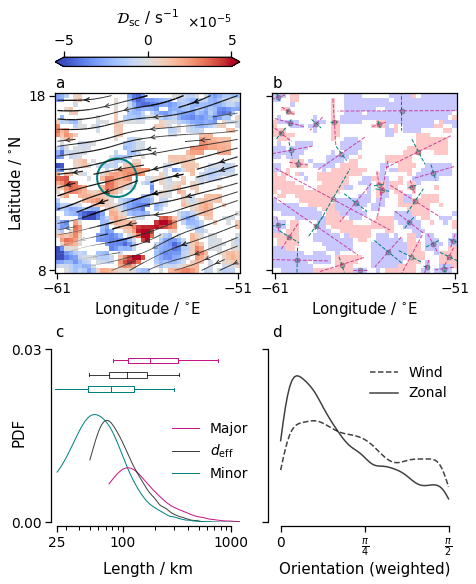

In [83]:
import matplotlib.colors
norm = matplotlib.colors.Normalize(vmin=8,vmax=15.,clip=False)
cmap = matplotlib.colors.ListedColormap(plt.cm.Greys(np.linspace(0.25,1,10)), "name")

sb.set_context('notebook',font_scale=1.25)
f,ax = plt.subplots(2,2,figsize=(6.5,8),constrained_layout=True,sharey='row')

time_id = 609 # only changes the top row, statistics in bottom row are unaffected
# Some nice time_ids : 14, 185, 264, 281, 307, 382, 555, 588, 609 -> the last one is the one used in the paper

min_lon = ds_all.longitude.min()
max_lon = ds_all.longitude.max()

min_lat = ds_all.latitude.min()
max_lat = ds_all.latitude.max()

a = np.arange(41)
np.interp(a, (a.min(), a.max()), (min_lon,max_lon))

u_sc = ds_all.isel(time=time_id).u.sel(alt=slice(0,610)).mean(dim='alt').coarsen(latitude=1,boundary='pad').mean().coarsen(longitude=1,boundary='pad').mean()
v_sc = ds_all.isel(time=time_id).v.sel(alt=slice(0,610)).mean(dim='alt').coarsen(latitude=1,boundary='pad').mean().coarsen(longitude=1,boundary='pad').mean()

wspd = np.sqrt(u_sc**2 + v_sc**2)

im = era5.Y.isel(time=time_id).plot.pcolormesh(ax=ax[0,0],cmap='coolwarm',vmin=-5e-5,vmax=5e-5,add_colorbar=False)
ax[0,0].streamplot(u_sc.longitude.values, u_sc.latitude.values, u_sc.values, v_sc.values, 
color=(wspd.values/np.mean(wspd.values)),density=[.7,.7],linewidth=(wspd.values/np.mean(wspd.values))**3,arrowstyle='->',cmap=cmap)

era5.X.isel(time=time_id).plot.pcolormesh(ax=ax[0,1],cmap='bwr',vmin=-3.5,vmax=3.5,add_colorbar=False,alpha=0.75)

fmt = mpl.ticker.ScalarFormatter(useMathText=True)
cax = f.colorbar(im, ax=ax[0, 0], location='top',extend='both',format=fmt)
cax.set_ticks([-5e-5,0,5e-5])
cax.set_label('$\mathcal{D}_{\mathrm{sc}}$ / s$^{-1}$',labelpad=10)


patches = Circle((-57.7,13.3), 1.1, color='teal',fill=False,linestyle='-',linewidth=2)
ax[0,0].add_patch(patches)
[ax[0,m].set_xlabel('Longitude / $^{\circ}$E') for m in range(2)]
ax[0,0].set_ylabel('Latitude / $^{\circ}$N')
ax[0,1].set_ylabel('')

[ax[0,m].set_title('') for m in range(2)]
ax[0,0].set_yticks(np.arange(8,18.1,10))
ax[0,1].set_yticks(np.arange(8,18.1,10))
ax[0,0].set_xticks(np.arange(-61,-50.9,10))
ax[0,1].set_xticks(np.arange(-61,-50.9,10))

regions = regionprops(label(ds_all.X.isel(time=time_id),connectivity=1))

for props in regions:

    if props.axis_major_length > 3 :

        y0 = np.interp(props.centroid[0], (a.min(), a.max()), (min_lat,max_lat)) 
        x0 = np.interp(props.centroid[1], (a.min(), a.max()), (min_lon,max_lon)) 

        orientation = props.orientation

        xmi1 = x0 - math.cos(orientation) * 0.5 * props.axis_minor_length*0.25 
        xmi2 = x0 + math.cos(orientation) * 0.5 * props.axis_minor_length*0.25 
        
        ymi1 = y0 + math.sin(orientation) * 0.5 * props.axis_minor_length*0.25 
        ymi2 = y0 - math.sin(orientation) * 0.5 * props.axis_minor_length*0.25 

        x2 = x0 - math.sin(orientation) * 0.5 * props.axis_major_length*0.25 
        y2 = y0 - math.cos(orientation) * 0.5 * props.axis_major_length*0.25

        x1 = x0 + math.sin(orientation) * 0.5 * props.axis_major_length*0.25 
        y1 = y0 + math.cos(orientation) * 0.5 * props.axis_major_length*0.25

        ax[0,1].scatter(x0, y0,  s=25, c='k',alpha=0.25)

        ax[0,1].plot((xmi1, xmi2), (ymi1, ymi2), 'teal', alpha=1, linewidth=1.,linestyle='--')
        ax[0,1].plot((x1, x2), (y1, y2), 'mediumvioletred', alpha=0.75, linewidth=1.,linestyle='--')

ax[0,0].set_title('a',loc='left')
ax[0,1].set_title('b',loc='left')

pars = ['axis_major_length','equivalent_diameter_area','axis_minor_length',]
colors = ['mediumvioletred','k','teal',]
alphas = [1,.75,1,]
kde_labels = ['Major','$d_{\mathrm{eff}}$','Minor',]
dist_lows = [75,50,25]
positions = [0.0280,0.0255,.023,] 

for id_,par in enumerate(pars):
    data = ds_all[par].values[~np.isnan(ds_all[par].values)].flatten()*25
    kde = gaussian_kde(data)
    dist_space = linspace(dist_lows[id_], 2000, 1000)
    normalized_kde = kde(dist_space)/kde(dist_space).sum()
    ax[1,0].plot(dist_space,normalized_kde,color=colors[id_],alpha=alphas[id_],linestyle='-',linewidth=1,label=kde_labels[id_])
    ca_dicts = {'color':colors[id_],'alpha':alphas[id_]}
    dict_props = dict(boxprops=ca_dicts,whiskerprops=ca_dicts,capprops=ca_dicts,medianprops=ca_dicts,meanprops=ca_dicts)

    ax[1,0].boxplot([data],vert=False,sym='',showmeans=False,positions=[positions[id_]],widths=[0.001],meanline=False,whis=(5,95),manage_ticks=False,**dict_props)

ax[1,0].set_xlabel('Length / km',labelpad=12)
ax[1,0].set_ylabel('PDF',labelpad=-15)

ax[1,0].set_xscale('log')
ax[1,0].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax[1,0].set_xlim(24,1200)
ax[1,0].set_xticks([25,100,1000])
ax[1,0].legend(frameon=False,loc=(0.6,0.2))
ax[1,0].set_title('c',loc='left')

#### Subplot-4

data = ds_all.orientation_wrt_wdir_domain.values[~np.isnan(ds_all.orientation_wrt_wdir_domain.values)].flatten()
weight = ds_all.area.values[~np.isnan(ds_all.orientation_wrt_wdir_domain.values)].flatten()
# Create the kernel, given an array it will estimate the probability over that values
kde_w = gaussian_kde(data,weights=weight)
# these are the values over which kernel will be evaluated
dist_space = linspace( min(data),max(data),75)
normalized_kde_w = kde_w(dist_space)/kde_w(dist_space).sum()
ax[1,1].plot(dist_space,normalized_kde_w,label='Wind',c='k',linestyle='--',alpha=0.75);  

data = np.pi/2 - np.sqrt(ds_all.orientation.values[~np.isnan(ds_all.orientation.values)].flatten()**2)
weight = ds_all.area.values[~np.isnan(ds_all.orientation.values)].flatten()
kde_w = gaussian_kde(data,weights=weight)
dist_space = linspace( min(data),max(data),75)
normalized_kde_w = kde_w(dist_space)/kde_w(dist_space).sum()
ax[1,1].plot(dist_space,normalized_kde_w,label='Zonal',c='k',linestyle='-',alpha=0.75);  

ax[1,1].legend(frameon=False,loc=(0.5,0.65))
ax[1,1].set_xlabel('Orientation (weighted)')
ax[1,1].set_ylabel('')
ax[1,1].set_xticks([0,np.pi/4,np.pi/2])
ax[1,1].set_xticklabels([0,'$\\frac{\pi}{4}$','$\\frac{\pi}{2}$'])

ax[1,1].set_title('d',loc='left')
ax[1,1].set_ylim(0,3.1e-2)
ax[1,1].set_yticks(np.arange(0,3.1e-2,3e-2))

sb.despine(ax=ax[1,1],trim=True,offset=4)
sb.despine(ax=ax[1,0],trim=True,offset=4) 

plt.savefig('sandbox/geometric_properties_of_smocs_with_orientation_wrt_wind.pdf',bbox_inches='tight')